In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [15]:
def load_data(subject_id, device, sensor):
    filepath = f'../dataset/{device}_csv/{sensor}/data_{subject_id}_{sensor}_{device}.csv'
    df = pd.read_csv(filepath)
    print(df['timestamp'].min(), df['timestamp'].max())
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    return df

subject_1600_data = load_data('1600', 'phone', 'accel')

print(f"Total data shape for subject 1600: {subject_1600_data.shape}")

subject_1600_data.head()

241598622217012 254351103296079
Total data shape for subject 1600: (64311, 6)


,subject_id,activity_code,timestamp,x,y,z
0,1600,A,1970-01-03 22:03:27.666810782,-0.364761,8.793503,1.055084
1,1600,A,1970-01-03 22:03:27.717164786,-0.879730,9.768784,1.016998
2,1600,A,1970-01-03 22:03:27.767518790,2.001495,11.109070,2.619156
3,1600,A,1970-01-03 22:03:27.817872794,0.450623,12.651642,0.184555
4,1600,A,1970-01-03 22:03:27.868226798,-2.164352,13.928436,-4.422485


Total segments found: 18
   subject_id activity_code  timestamp         x          y         z  \
0        1600             A   0.000000 -0.364761   8.793503  1.055084   
1        1600             A   0.050354 -0.879730   9.768784  1.016998   
2        1600             A   0.100708  2.001495  11.109070  2.619156   
3        1600             A   0.151062  0.450623  12.651642  0.184555   
4        1600             A   0.201416 -2.164352  13.928436 -4.422485   

   segment_id  
0           0  
1           0  
2           0  
3           0  
4           0  
Segment 1 shape: (3574, 7)


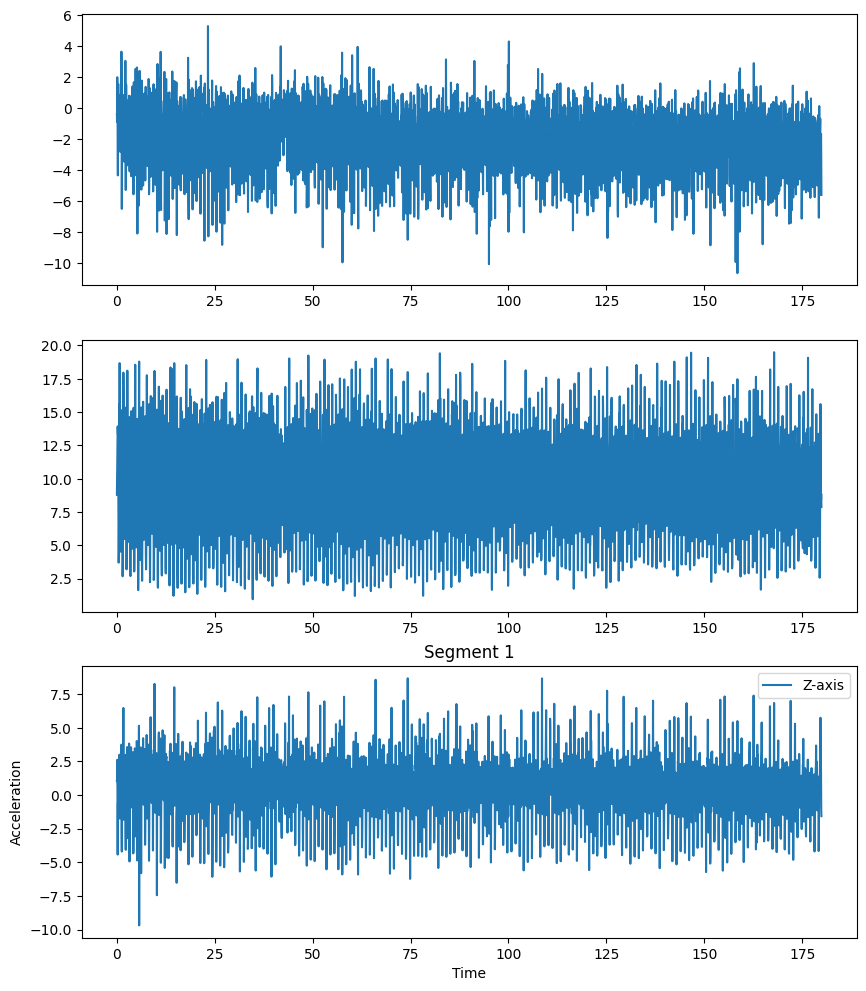

Segment 2 shape: (3572, 7)


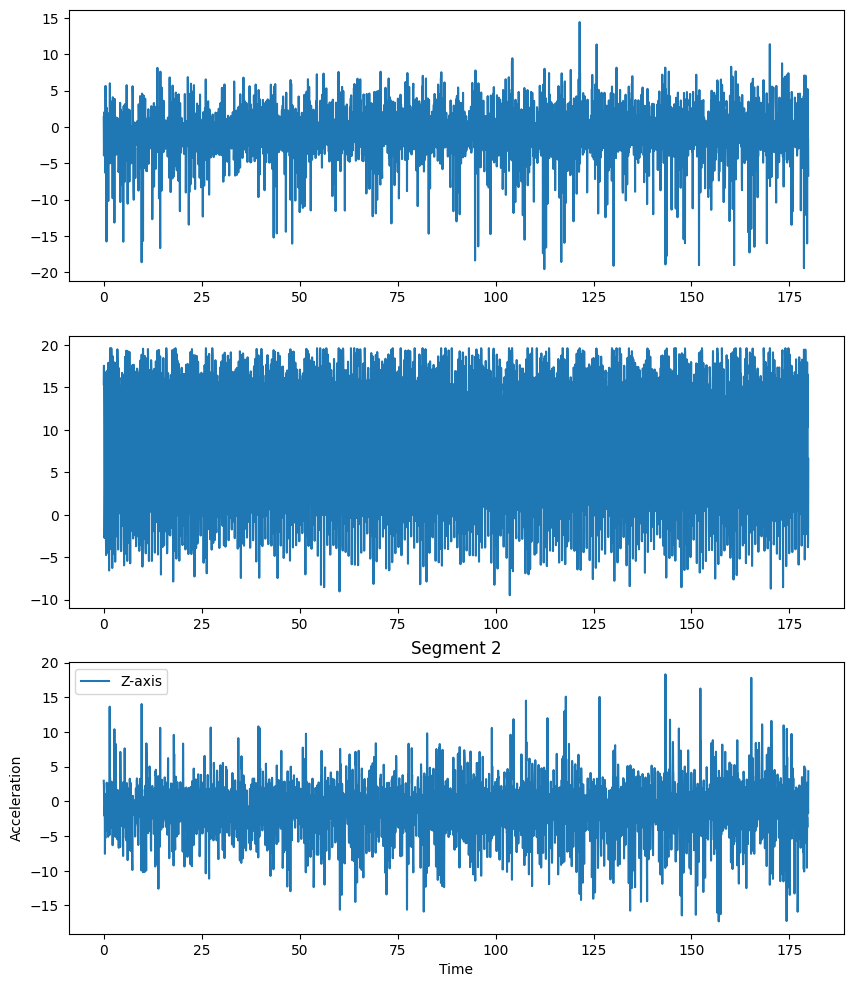

In [ ]:
def split_df_into_segments(df, time_col='timestamp', threshold=pd.Timedelta('1s')):
    time_diffs = df[time_col].diff().fillna(pd.Timedelta(seconds=0))
    segment_ids = (abs(time_diffs) > threshold).cumsum()
    segments = [group.reset_index(drop=True) for _, group in df.groupby(segment_ids)]
    for segment in segments:
        segment['timestamp'] = (segment[time_col] - segment[time_col].min()).dt.total_seconds()

    return segments

segments = split_df_into_segments(subject_1600_data)

print(f"Total segments found: {len(segments)}")
print(segments[0].head())

for i, segment in enumerate(segments[:2]):
    print(f"Segment {i+1} shape: {segment.shape}")
    plt.figure(figsize=(10, 12))

    plt.subplot(3, 1, 1)
    plt.plot(segment['timestamp'], segment['x'], label='X-axis')

    plt.subplot(3, 1, 2)
    plt.plot(segment['timestamp'], segment['y'], label='Y-axis')

    plt.subplot(3, 1, 3)
    plt.plot(segment['timestamp'], segment['z'], label='Z-axis')

    plt.title(f'Segment {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.show()


In [ ]:
def create_windowed_dataframe(segment, window_size=50, step_size=25):
    windows = []
    for start in range(0, len(segment) - window_size + 1, step_size):
        window = segment.iloc[start:start + window_size].copy()
        if len(window) == window_size:
            windows.append(window.reset_index(drop=True))
    
    

Total windows created from first segment: 141
   subject_id activity_code  timestamp         x          y         z  \
0        1600             A   0.000000 -0.364761   8.793503  1.055084   
1        1600             A   0.050354 -0.879730   9.768784  1.016998   
2        1600             A   0.100708  2.001495  11.109070  2.619156   
3        1600             A   0.151062  0.450623  12.651642  0.184555   
4        1600             A   0.201416 -2.164352  13.928436 -4.422485   

   segment_id  
0           0  
1           0  
2           0  
3           0  
4           0  
